In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# task dictionary
task_dict = {
    'stroop_vanilla': 'task-td7i',
    'stroop_progressbar': 'task-lupf',
    'stroop_eyes': 'task-c9op',
    'stroop_video': 'task-1l71',
    'stroop_posneg': 'task-on6n',
    'stroop_final': 'task-7g42',
    'stroop_bonus': 'task-3kpz',
    'rdk_vanilla': 'task-2ywa',
    'rdk_progressbar': 'task-sks3',
    'rdk_eyes': 'task-zyvq',
    'rdk_video': 'task-6e3k',
    'rdk_posneg': 'task-ivrk',
    'rdk_final': 'task-sq3v',
    'rdk_bonus': 'task-hvii',
    'bandit_vanilla': 'task-dwkr',
    'bandit_progressbar': 'task-25bt',
    'bandit_eyes': 'task-x158',
    'bandit_video': 'task-9ndm',
    'bandit_posneg': 'task-tzk1',
    'bandit_final': 'task-gn7s',
    'bandit_bonus': 'task-iaas',
}

# task-separated arrays
stroop_arr = ["stroop_vanilla", "stroop_progressbar", "stroop_eyes", "stroop_video", "stroop_posneg", "stroop_final", "stroop_bonus"]
rdk_arr = ["rdk_vanilla", "rdk_progressbar", "rdk_eyes", "rdk_video", "rdk_posneg", "rdk_final", "rdk_bonus"]
bandit_arr = ["bandit_vanilla", "bandit_progressbar", "bandit_eyes", "bandit_video", "bandit_posneg", "bandit_final", "bandit_bonus"]

In [3]:
# reading trimmed bandit dataset

bandit_df = pd.read_csv('data/bandit_df.csv')

C:\Users\Devank\AppData\Local\Temp/ipykernel_6652/2770900496.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  bandit_df = pd.read_csv('data/bandit_df.csv')


### I. BANDIT ACCURACY USING BEST ARM SELECTION

In [4]:
response_mapper = {
    "left": "Stimuli 1",
    "top": "Stimuli 2",
    "right": "Stimuli 3",
    "bottom": "Stimuli 4"
}

In [5]:
def best_arm_accuracy_calculator():
    accuracies = []
    for manip in bandit_arr:

        focus_df = bandit_df[bandit_df['Tree Node Key'] == task_dict[manip]]
        participants = pd.unique(focus_df['Participant Private ID'])
        overall_accuracy = 0.0
        if participants.size < 1:
            accuracies.append(overall_accuracy)
            continue

        for participant in participants:
            participant_df = focus_df[focus_df['Participant Private ID'] == participant]
            participant_df = participant_df[participant_df["Screen Name"] == "trial"][["Response", "Best Choice", "Stimuli 1", "Stimuli 2", "Stimuli 3", "Stimuli 4"]]
            trial_count = len(participant_df)
            participant_df = participant_df.replace({"Response": response_mapper}).dropna().reset_index()
            participant_df["New"] = participant_df.values[participant_df.index, participant_df.columns.get_indexer(participant_df["Response"])]
            correct_count = participant_df["New"].eq(participant_df["Best Choice"]).sum()
            accuracy = correct_count / trial_count
            overall_accuracy += accuracy

        overall_accuracy /= participants.size
        accuracies.append(overall_accuracy * 100)

    return accuracies

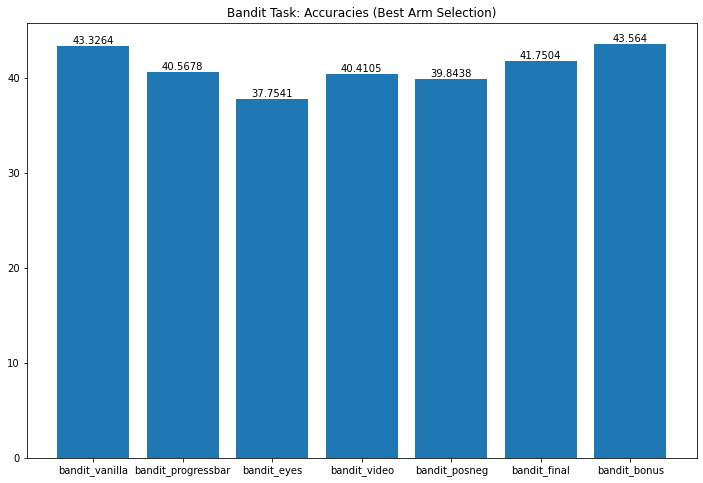

In [6]:
bandit_best_arm_accuracies = best_arm_accuracy_calculator()

fig, ax = plt.subplots(figsize=(12,8))
plot = ax.bar(bandit_arr, bandit_best_arm_accuracies)
ax.bar_label(plot)
ax.set_title('Bandit Task: Accuracies (Best Arm Selection)')
plt.show()

In [7]:
def best_arm_accuracies_per_task(task):
    
    accuracies = []
    task_arr = []

    focus_df = bandit_df[bandit_df['Tree Node Key'] == task_dict[task]]
    participants = pd.unique(focus_df['Participant Private ID'])

    for participant in participants:
        participant_df = focus_df[focus_df['Participant Private ID'] == participant]
        participant_df = participant_df[participant_df["Screen Name"] == "trial"][["Response", "Best Choice", "Stimuli 1", "Stimuli 2", "Stimuli 3", "Stimuli 4"]]
        trial_count = len(participant_df)
        participant_df = participant_df.replace({"Response": response_mapper}).dropna().reset_index()
        participant_df["New"] = participant_df.values[participant_df.index, participant_df.columns.get_indexer(participant_df["Response"])]
        correct_count = participant_df["New"].eq(participant_df["Best Choice"]).sum()
        
        accuracy = correct_count / trial_count
        accuracies.append(accuracy * 100)
        task_arr.append(task)

    return task_arr, accuracies

[Text(0.5, 1.0, 'Bandit Task: Best Arm Accuracies per Task')]

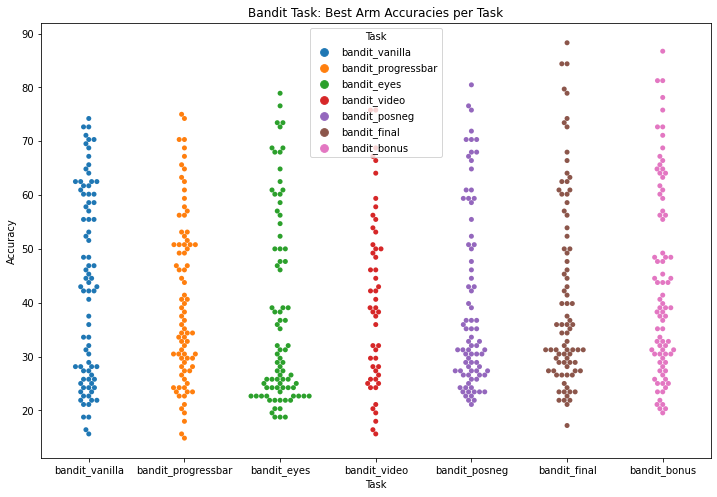

In [8]:
bandit_accuracies = []
bandit_tasks = []
for manip in bandit_arr:
    manip_arr, manip_acc = best_arm_accuracies_per_task(manip)
    bandit_accuracies.append(manip_acc)
    bandit_tasks.append(manip_arr)
    
bandit_accuracies = [item for sublist in bandit_accuracies for item in sublist]
bandit_tasks = [item for sublist in bandit_tasks for item in sublist]
bandit_acc_df = pd.DataFrame({'Task': bandit_tasks, 'Accuracy': bandit_accuracies})
fig = plt.figure(figsize=(12,8))

# sns.boxplot(data=bandit_acc_df, x = 'Task', y='Accuracy', hue='Task')
sns.swarmplot(data=bandit_acc_df, x = 'Task', y='Accuracy', hue='Task').set(title="Bandit Task: Best Arm Accuracies per Task")

### II. EVOLUTION OF ACCURACY WITH EVERY BLOCK

In [9]:
def get_posneg_df(df, arr):
    
    final_list = []
    manip = [m for m in arr if 'bonus' in m][0]
    focus_df = df[df['Tree Node Key'] == task_dict[manip]]
    participants = pd.unique(focus_df['Participant Private ID'])
    
    for participant in participants:
        participant_df = focus_df[focus_df['Participant Private ID'] == participant]
        participant_df = participant_df[participant_df['Screen Name'] == 'trial'][['Participant Private ID', "Response", "Best Choice", "Stimuli 1", "Stimuli 2", "Stimuli 3", "Stimuli 4"]]
        participant_df["Participant Private ID"].astype(str)
        final_list.append(participant_df)
    
    return pd.concat(final_list)

In [10]:
def results_per_participant_posneg(focus_df):
    
    results_posneg_df = pd.DataFrame(columns=['Participant', 'Block', 'Accuracy'])
    participants = pd.unique(focus_df['Participant Private ID'])
    
    for participant in participants:
        participant_df = focus_df[focus_df['Participant Private ID'] == participant]
        first_index = 0
        
        for i in range(len(participant_df) // 16):
            block_df = participant_df[first_index:first_index+16]
            block_df = block_df.replace({"Response": response_mapper}).dropna().reset_index()
            block_df["New"] = block_df.values[block_df.index, block_df.columns.get_indexer(block_df["Response"])]
            correct_count = block_df["New"].eq(block_df["Best Choice"]).sum()
            accuracy = correct_count / 16
            
            results_posneg_df = results_posneg_df.append({
                'Participant': participant,
                'Block': str(first_index/16),
                'Accuracy': accuracy
            }, ignore_index=True)
            first_index += 16
    
    return results_posneg_df

In [11]:
bandit_posneg_df = get_posneg_df(bandit_df, bandit_arr)
bandit_results_posneg_df = results_per_participant_posneg(bandit_posneg_df).groupby(["Block"]).mean().reset_index()

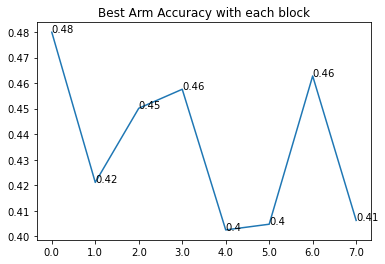

In [12]:
plt.plot(bandit_results_posneg_df["Block"], bandit_results_posneg_df["Accuracy"])
plt.title("Best Arm Accuracy with each block")
for a, b in zip(bandit_results_posneg_df["Block"], bandit_results_posneg_df["Accuracy"]): 
    plt.text(a, b, str(round(b, 2)))
plt.show()

### III. DIVIDING ACCURACIES INTO DECILES

In [13]:
def get_ordered_accuracies(df):
    accuracies = []
#     for manip in arr:

#         focus_df = df[df['Tree Node Key'] == task_dict[manip]]
    participants = df['Participant Private ID'].unique().tolist()

    for participant in participants:
        participant_df = df[df['Participant Private ID'] == participant]
        participant_df = participant_df[participant_df['Screen Name'] == 'trial'][['Attempt', 'Correct', 'Incorrect']]
        # for timeouts
        participant_df['Attempt'].fillna(0, inplace = True)

        if participant_df.empty:
            participants.remove(participant)
            continue

        accuracy = participant_df['Correct'].sum() / len(participant_df)
        accuracies.append(accuracy * 100)

    return sorted(accuracies, reverse=True)

In [14]:
stroop_accuracies = np.asarray(get_ordered_accuracies(stroop_df))
stroop_decile_thresholds = []
for i in [0, 15, 25, 35, 45, 55, 65, 75, 85, 100]:
    stroop_decile_thresholds.append(np.percentile(stroop_accuracies, i))
stroop_decile_thresholds

NameError: name 'stroop_df' is not defined

In [15]:
rdk_accuracies = np.asarray(get_ordered_accuracies(rdk_df))
rdk_decile_thresholds = []
for i in [0, 15, 25, 35, 45, 55, 65, 75, 85, 100]:
    rdk_decile_thresholds.append(np.percentile(rdk_accuracies, i))
rdk_decile_thresholds

NameError: name 'rdk_df' is not defined

In [16]:
bandit_accuracies = np.asarray(get_ordered_accuracies(bandit_df))
bandit_decile_thresholds = []
for i in [0, 15, 25, 35, 45, 55, 65, 75, 85, 100]:
    bandit_decile_thresholds.append(np.percentile(bandit_accuracies, i))
bandit_decile_thresholds

[22.65625,
 36.71875,
 38.28125,
 40.625,
 42.65624999999999,
 44.53125,
 46.09375,
 49.21875,
 52.34375,
 65.625]